# Comparative Analysis of Deep Learning Architectures for Earthquake Prediction

**AI7102: Introduction to Deep Learning - Project Proposal - Fall 2025**

**Team Members:** Mohamed Alrayssi, Majid Ibrahim, Hamdan Almehairbi, Mohammed Ibrahim Alblooshi

---
### Important Workflow

This project is split into two main parts:

1. **Training Pipeline (`main.py`)**: Handles data loading, feature engineering, model training, and evaluation. It generates `model_comparison_results.csv`, `best_model.pth`, and `val_loader.pth`.

2. **Analysis Notebook (`analysis_notebook.ipynb`)**: Used for visualizing results and analyzing the best-performing model.



To run this project correctly, you must first execute the main training script from your terminal:



```bash

python main.py

```



After the script finishes, you can run the cells in this notebook to analyze the generated results.


## 1. Setup and Environment


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.auto import tqdm
from scipy.stats import ks_2samp

# Import our project modules
import utils
import data_loader
import models # To load model architecture for error analysis

# Configure plotting style
utils.setup_plotting_style()


Plotting style configured.


## 2. Data Loading and Exploratory Analysis (EDA)

In [2]:
DATA_PATH = 'data/train.csv' # Assumes train.csv is in a /data subfolder
train_df = data_loader.load_data(DATA_PATH, nrows=60_000_000)
display(train_df.head())


Loaded 60,000,000 rows from data/train.csv


,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


Visualizing a sample of the raw time-series data:


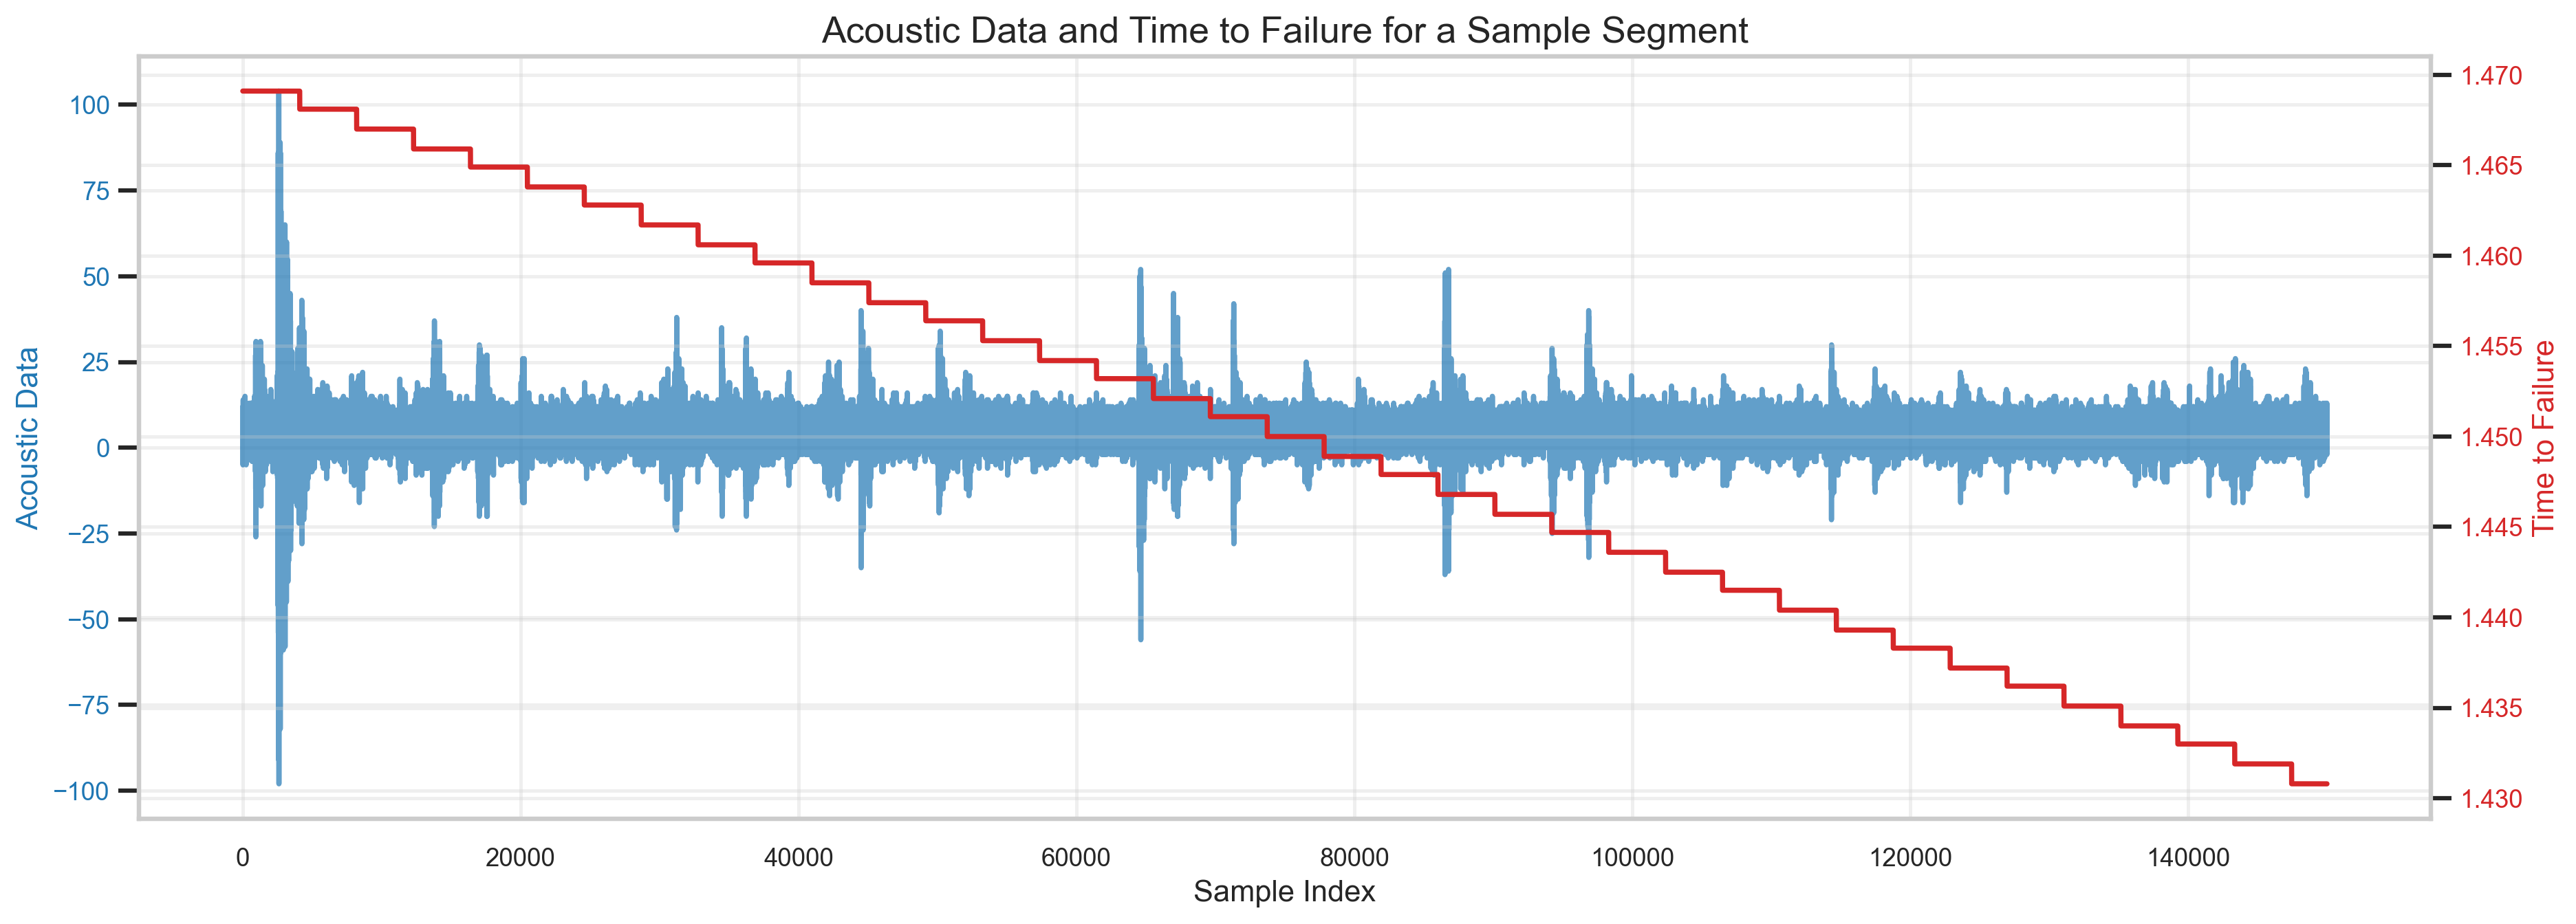

In [3]:
print("Visualizing a sample of the raw time-series data:")
data_loader.plot_eda_segment(train_df)


### Target Variable Distribution

This histogram shows the distribution of the final `time_to_failure` value for each 150,000-sample segment in the training data. The distribution is right-skewed, indicating that shorter times to failure are more common than very long ones. This is a critical characteristic for the model to learn.


Segmenting for Histogram:   0%|          | 0/400 [00:00<?, ?it/s]

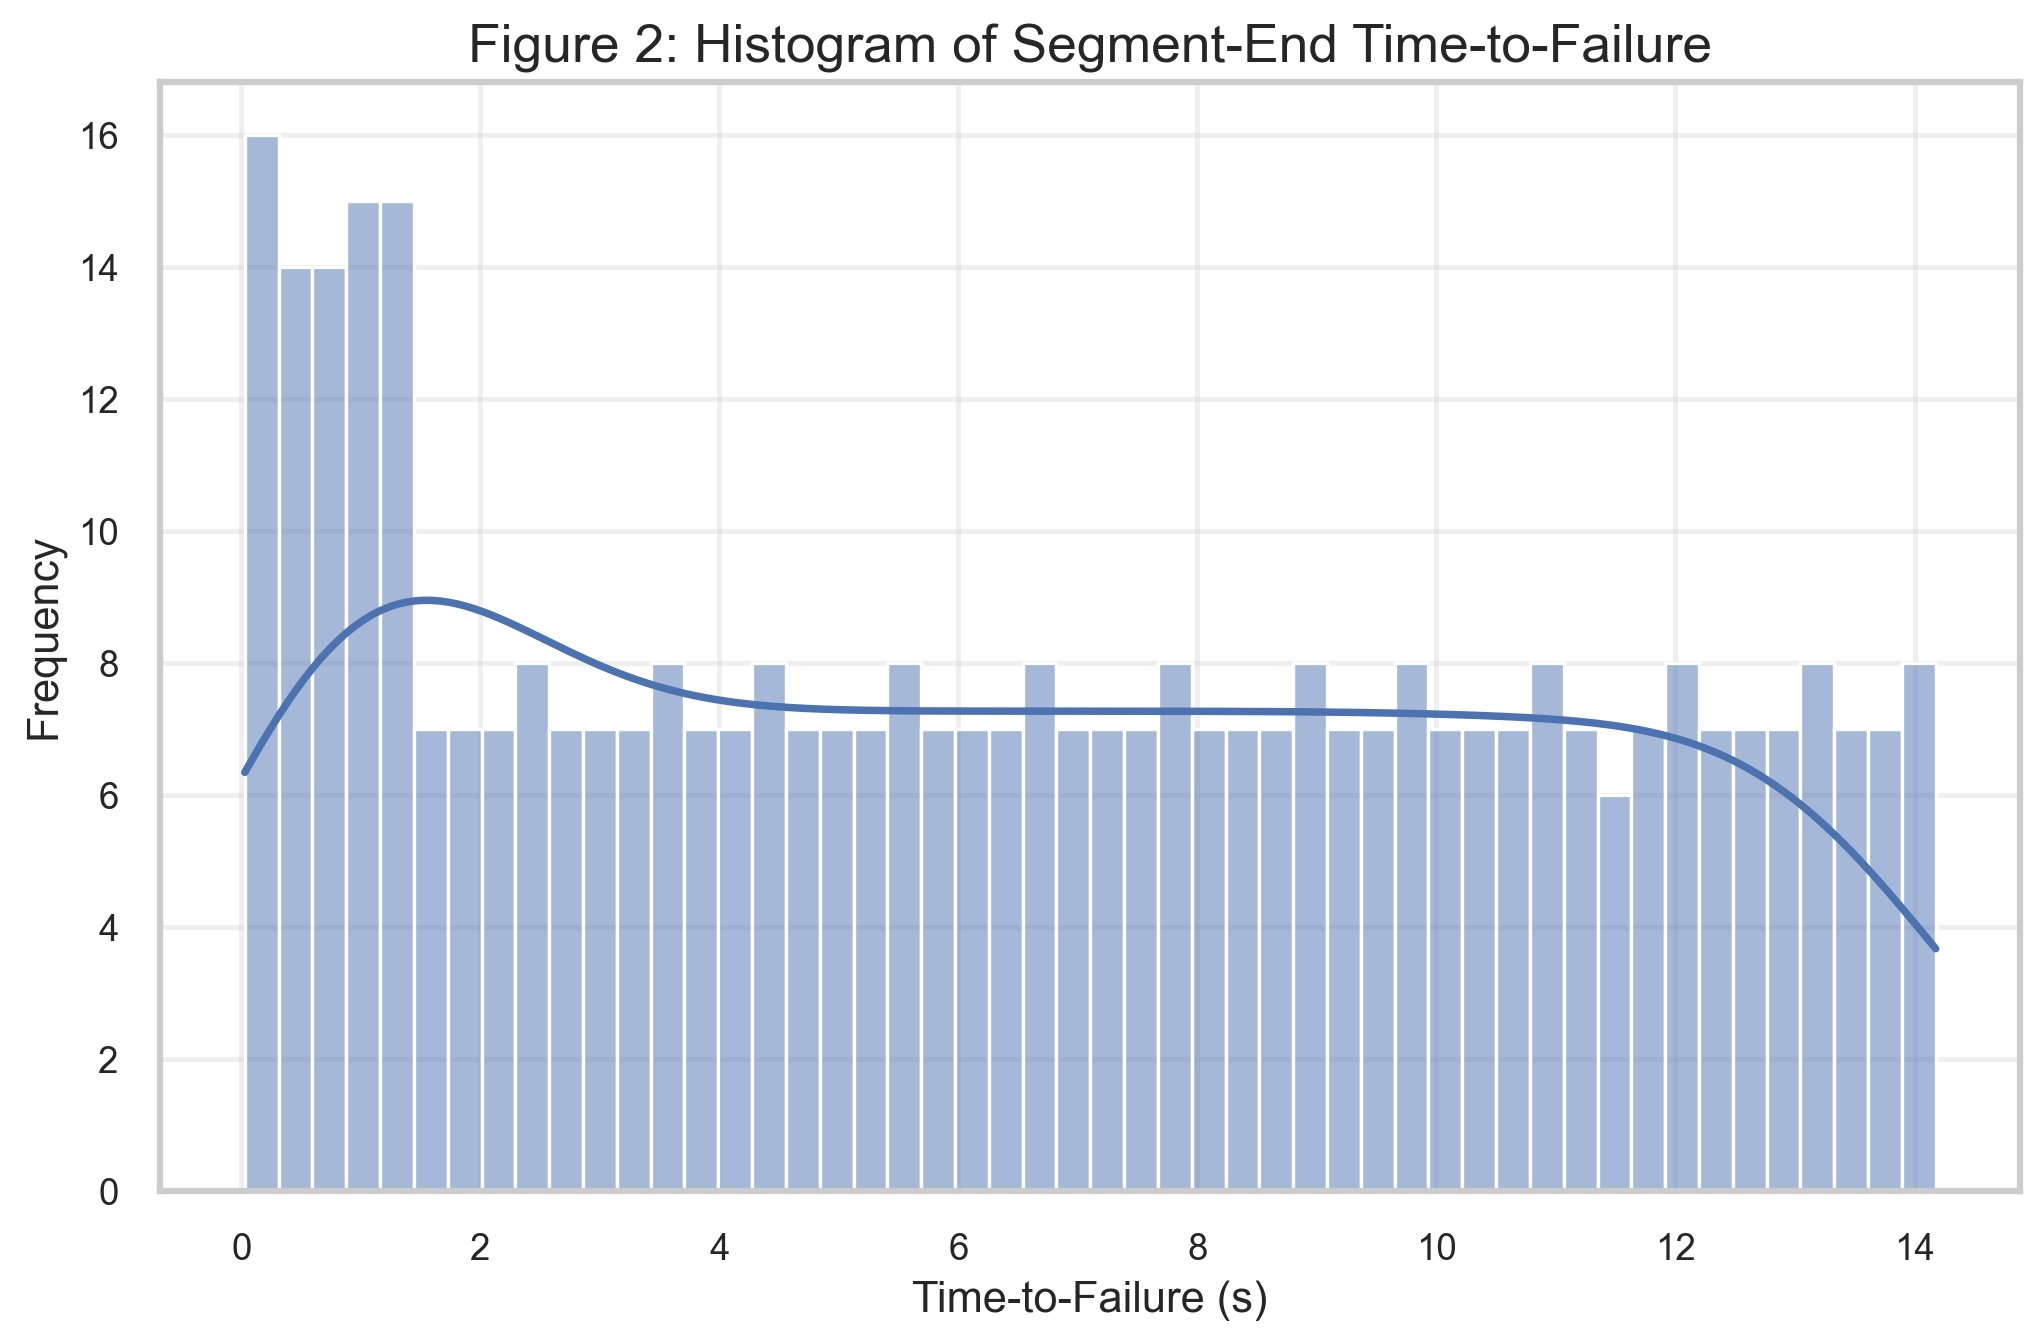

In [4]:
# Calculate the final time_to_failure for each segment
rows = 150_000
segments = len(train_df) // rows
y_train_hist = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

for idx in tqdm(range(segments), desc="Segmenting for Histogram"):
    seg = train_df.iloc[idx*rows : idx*rows + rows]
    y_train_hist.loc[idx, 'time_to_failure'] = seg['time_to_failure'].values[-1]

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(y_train_hist['time_to_failure'], bins=50, kde=True)
plt.xlabel('Time-to-Failure (s)')
plt.ylabel('Frequency')
plt.title('Figure 2: Histogram of Segment-End Time-to-Failure')
plt.show()


## 2a. Feature Exploration: Rolling Statistics

Before building complex features, we can explore simple transformations. This plot shows a rolling standard deviation of the acoustic signal. Smoothing the noisy raw signal this way helps reveal underlying patterns that correlate with the sawtooth shape of the `time_to_failure` signal. This motivates our more comprehensive feature engineering approach.


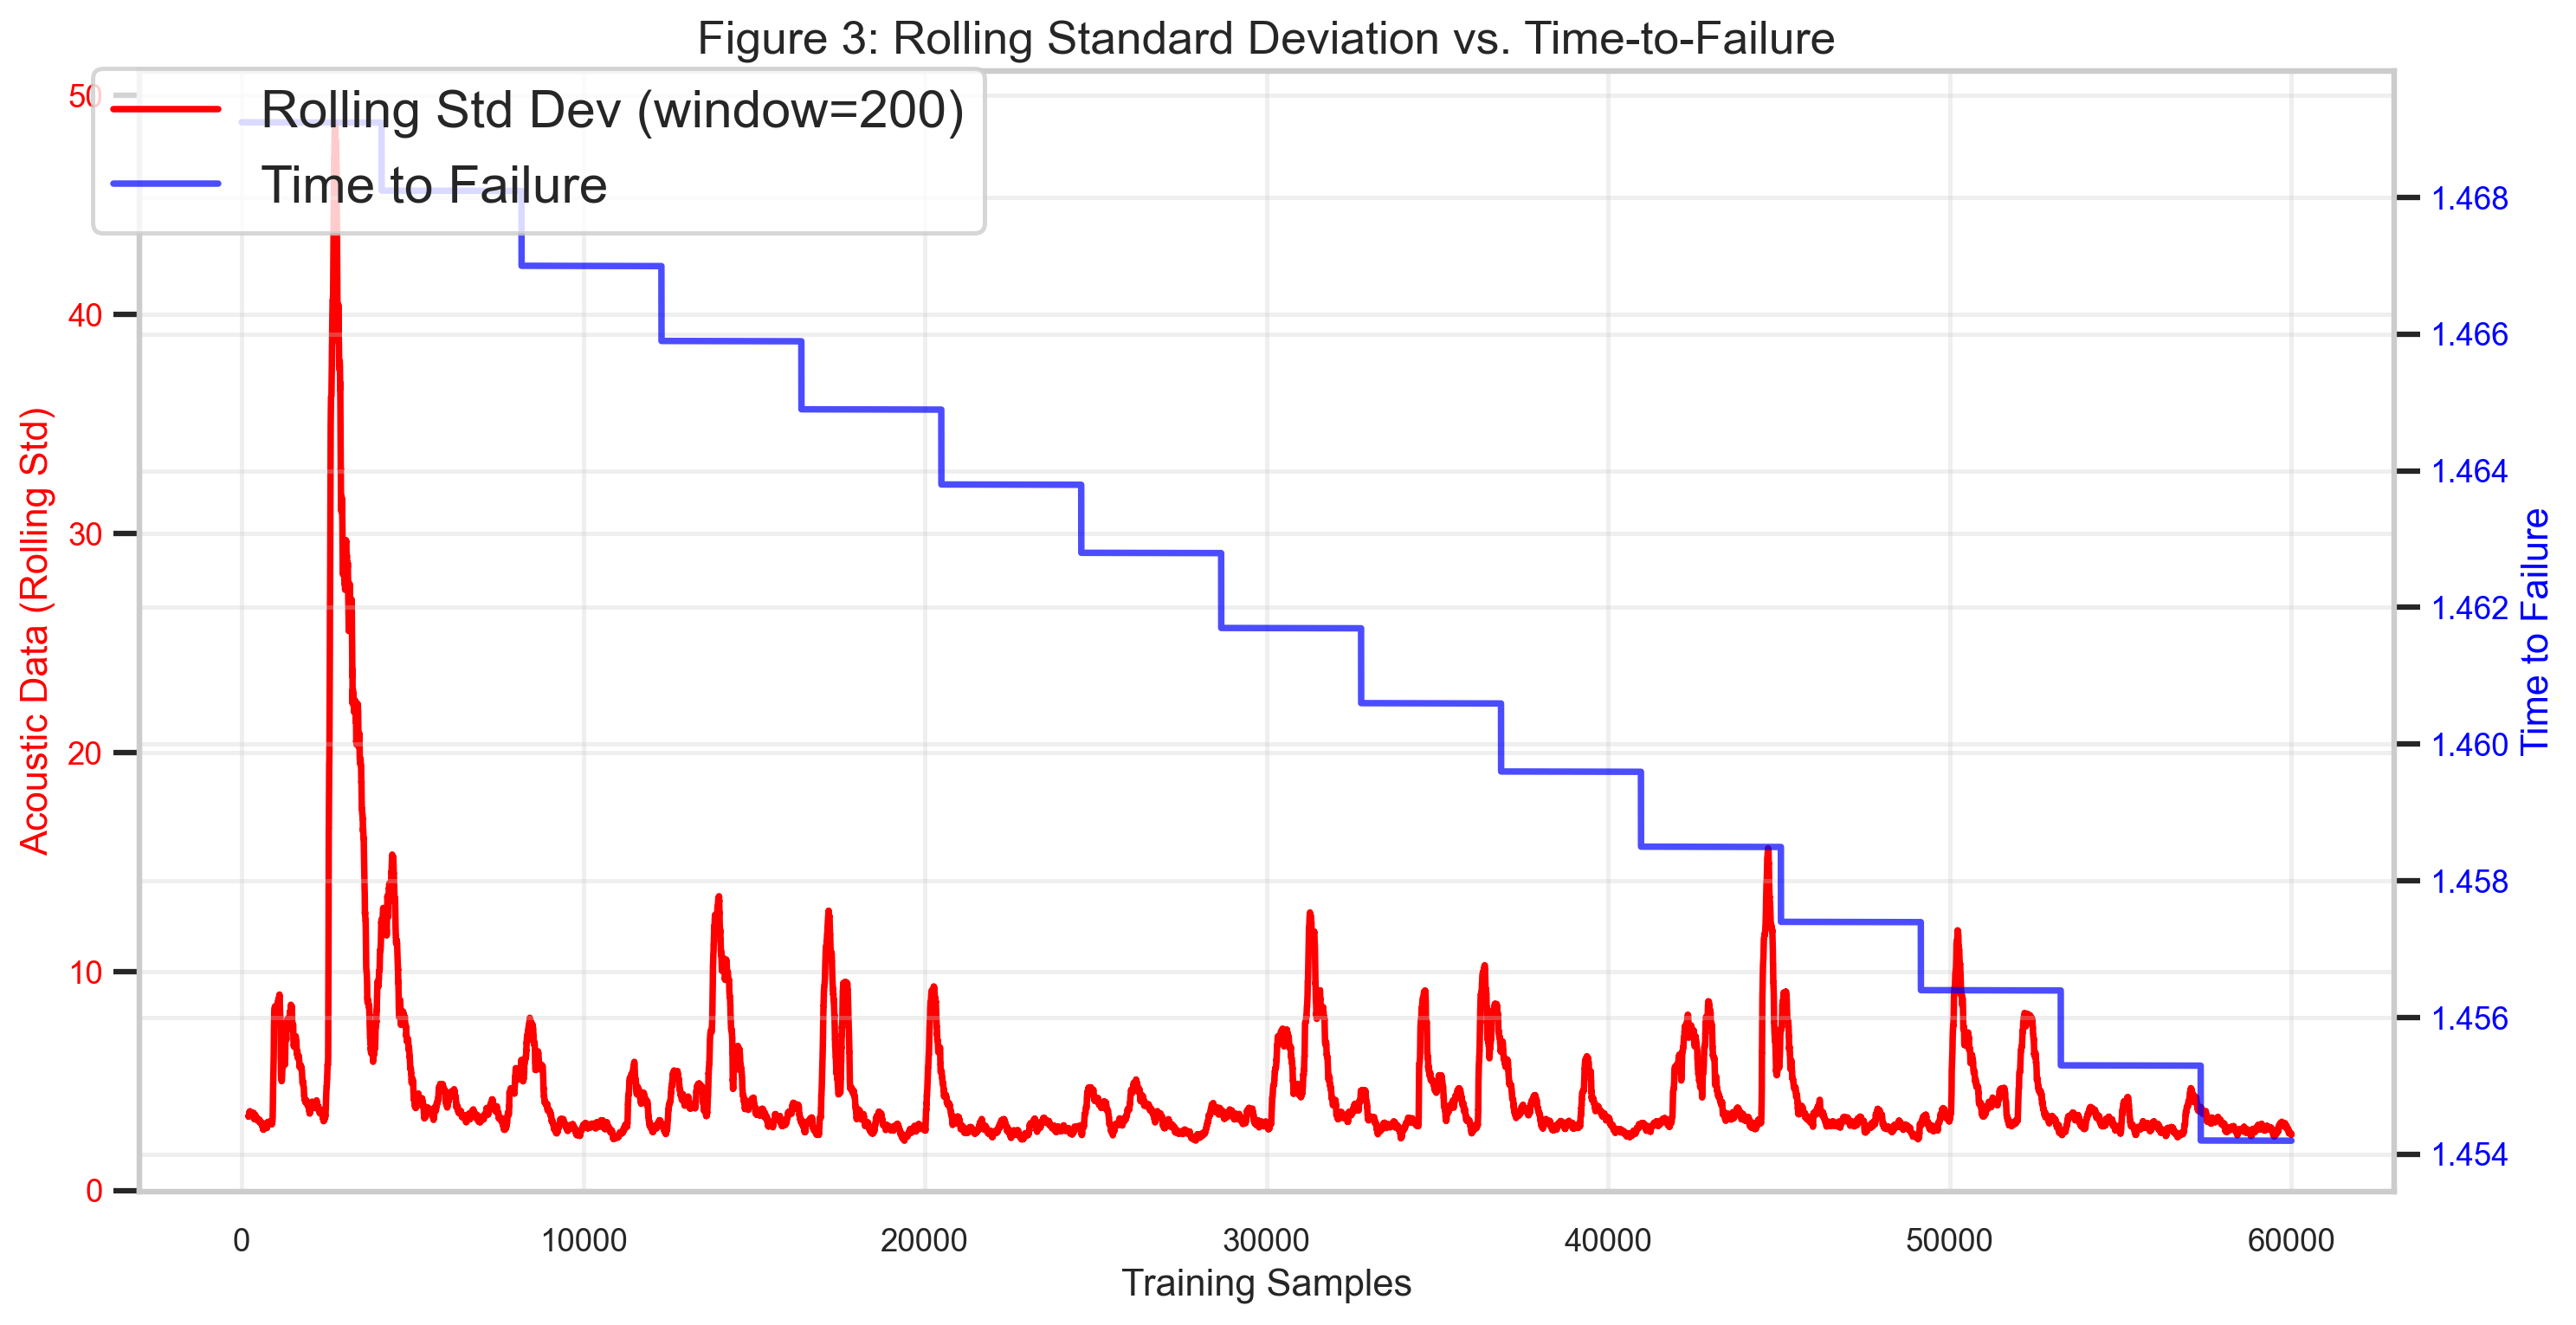

In [5]:
# Use a smaller slice of the data for performance
train_sample = train_df.iloc[:60000].copy()

# Calculate rolling standard deviation
window = 200
roll_std = train_sample['acoustic_data'].rolling(window=window).std().dropna()

fig, ax1 = plt.subplots(figsize=(14, 7))
plt.title('Figure 3: Rolling Standard Deviation vs. Time-to-Failure')

# Plot the rolling feature
ax1.plot(roll_std.index, roll_std.values, color='red', label='Rolling Std Dev (window=200)')
ax1.set_xlabel('Training Samples')
ax1.set_ylabel('Acoustic Data (Rolling Std)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Plot the time to failure on a second y-axis
ax2 = ax1.twinx()
ax2.plot(train_sample.index, train_sample['time_to_failure'], color='blue', alpha=0.7, label='Time to Failure')
ax2.set_ylabel('Time to Failure', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()


## 3. Feature Importance Analysis

Before diving into model results, let's understand which engineered features are most predictive using a simple linear model and permutation importance. This tells us what signal characteristics are most valuable.


In [6]:
from sklearn.linear_model import Ridge
from sklearn.inspection import permutation_importance
import data_pipeline

try:
    # We need the full dataset and feature names for this analysis
    df_full = data_loader.load_data('data/train.csv')
    _, _, _, feature_names = data_pipeline.prepare_data(df_full)
    
    # Re-run prepare_data to get the processed data
    train_loader_fi, val_loader_fi, _, feature_names = data_pipeline.prepare_data(df_full)
    
    # Extract data from loaders for analysis
    X_train_list, y_train_list = [], []
    for Xb, yb in train_loader_fi:
        X_train_list.append(Xb.numpy())
        y_train_list.append(yb.numpy())
    
    X_train_s = np.concatenate(X_train_list, axis=0)
    y_train_s = np.concatenate(y_train_list, axis=0)
    
    # Flatten data for linear model
    X_train_flat = X_train_s.reshape(-1, X_train_s.shape[-1])
    y_train_flat = np.repeat(y_train_s, X_train_s.shape[1])

    linear_model = Ridge(alpha=1.0).fit(X_train_flat, y_train_flat)
    
    result = permutation_importance(
        linear_model, X_train_flat, y_train_flat, n_repeats=5, random_state=42, n_jobs=-1
    )
    
    importances = pd.Series(result.importances_mean, index=feature_names).sort_values()
    
    plt.figure(figsize=(10, 8))
    importances.plot(kind='barh', color='skyblue')
    plt.title('Figure 6: Permutation Feature Importances (Linear Model)')
    plt.xlabel('Mean Importance (Decrease in R-squared)')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Feature importance analysis skipped: {e}")


Loaded 60,000,000 rows from data/train.csv
Starting data preparation: Engineering features into sequences...


  0%|          | 0/400 [00:00<?, ?it/s]


Final data shape for temporal models: (400, 10, 15)
Train shape: (320, 10, 15), Validation shape: (80, 10, 15)
Feature importance analysis skipped: too many values to unpack (expected 4)


### 3a. Advanced Feature Selection: KS Statistic Plot

To assess the quality of our engineered features, we can use the Kolmogorov-Smirnov (KS) statistic. This plot compares the distribution of a feature's values within a single earthquake cycle against its distribution in the test set. Features with consistently high KS statistics across different cycles may suffer from distribution shift and are less reliable.

*(Note: This is a demonstration with simulated data, as generating full test set features and identifying cycles is computationally intensive for this notebook.)*


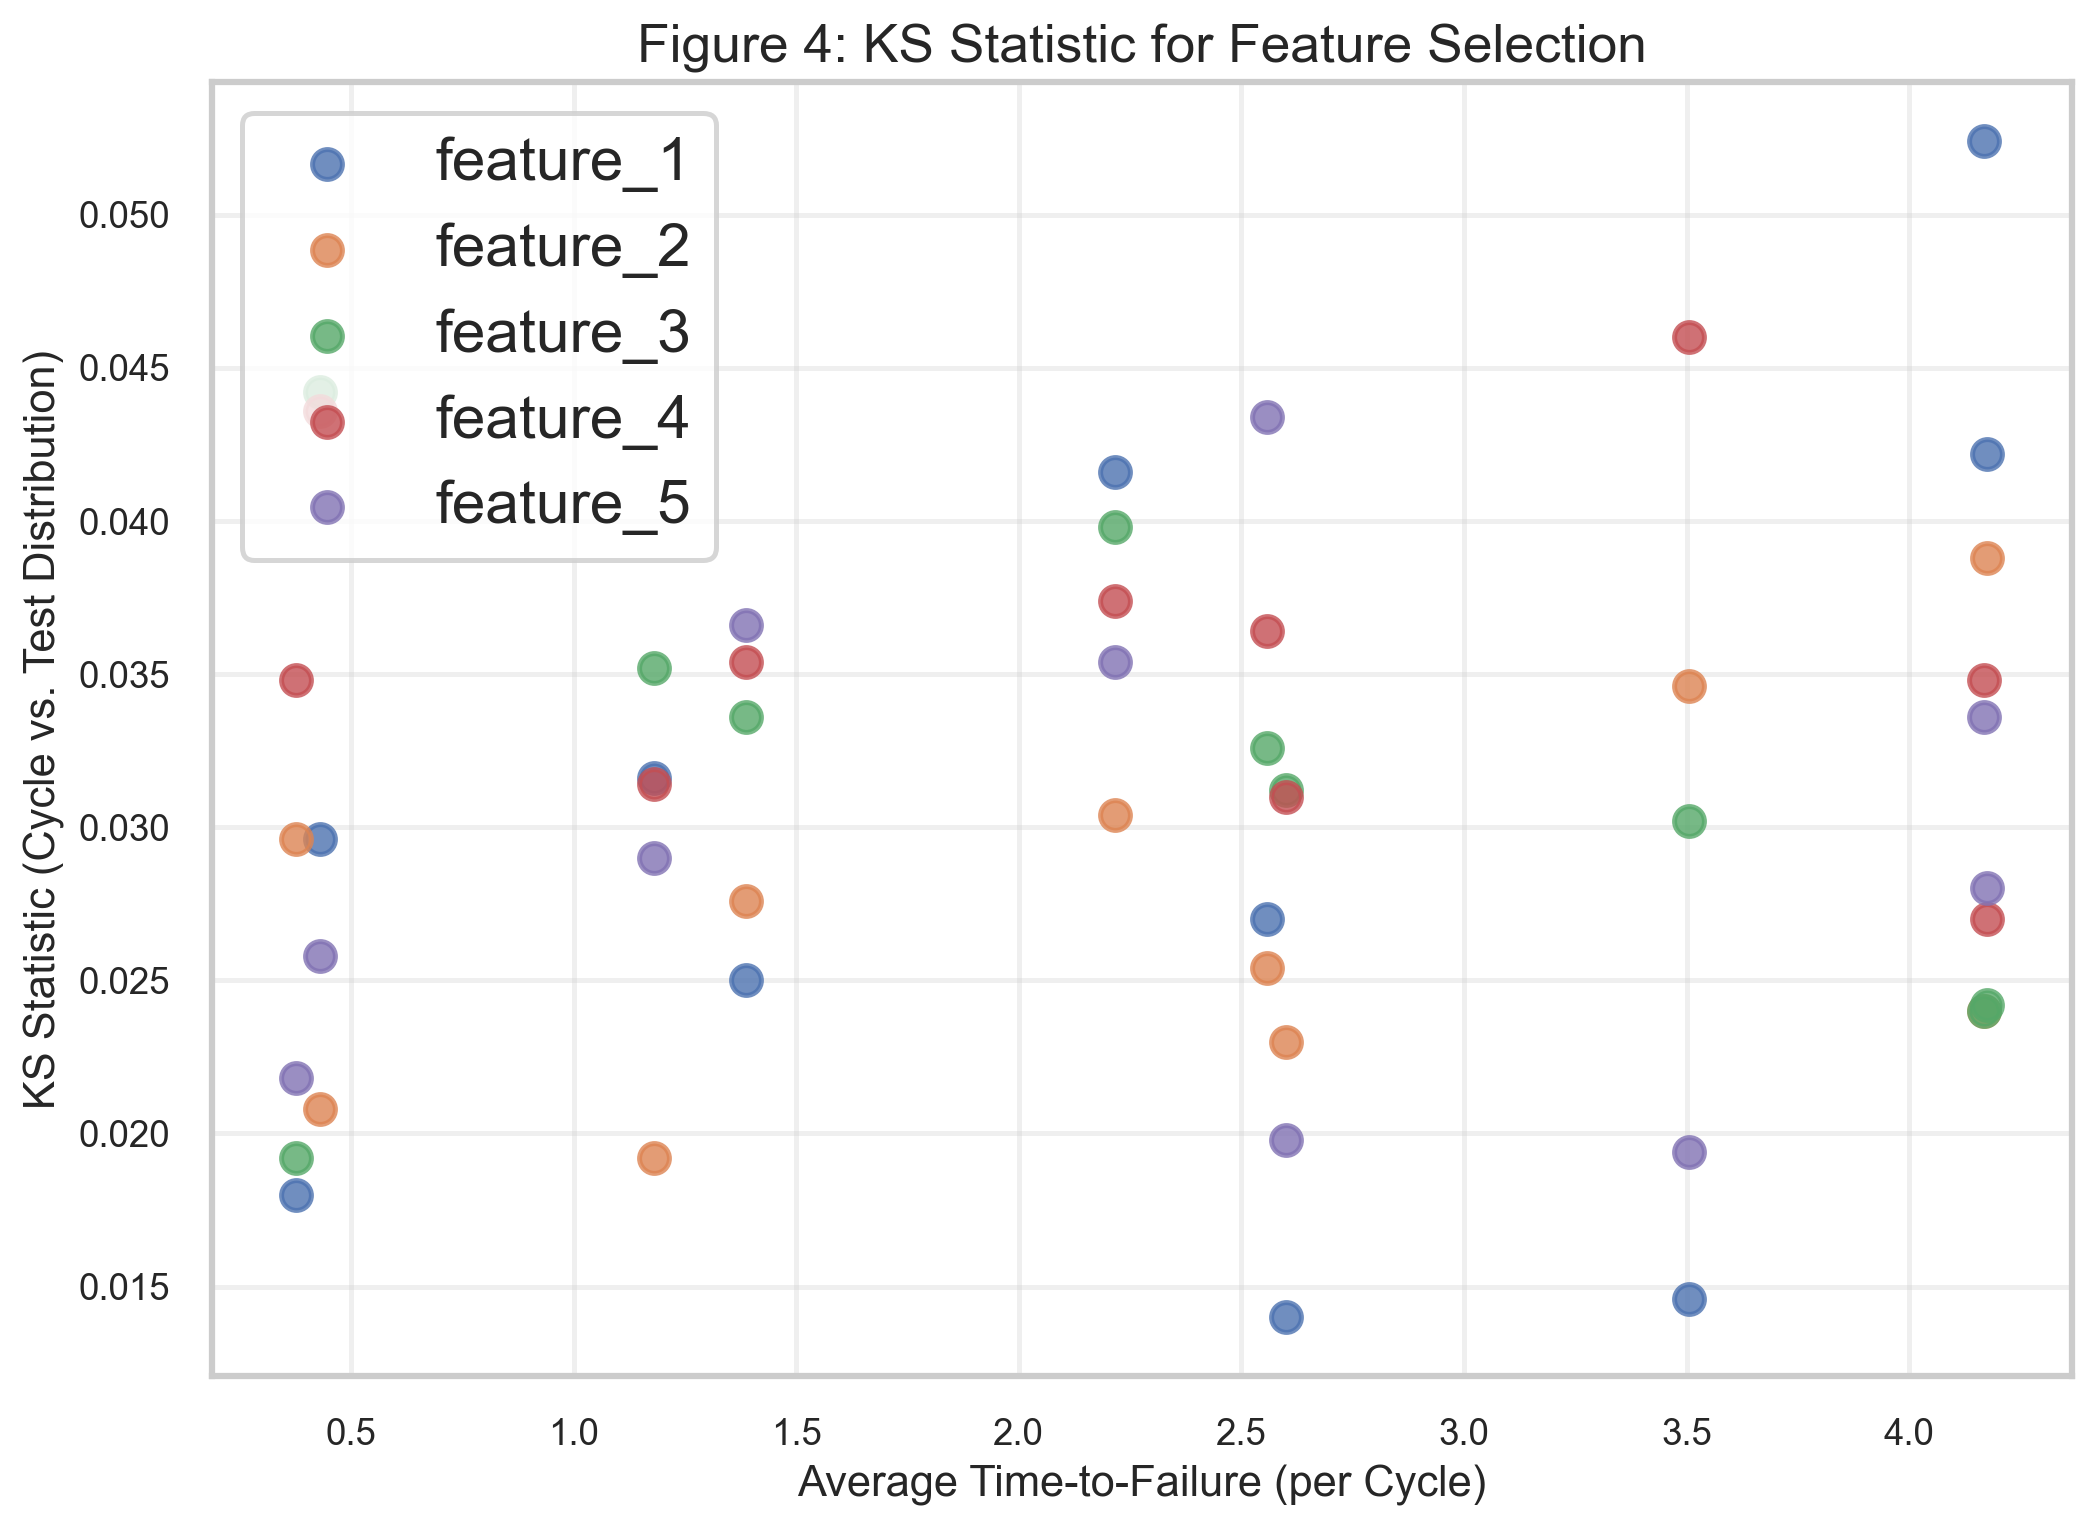

In [7]:
from scipy.stats import ks_2samp

# --- SIMULATED DATA FOR DEMONSTRATION ---
# In a real run, these would be derived from the actual data.
num_cycles = 10
num_features = 5
features_per_cycle = 1000

# Create dummy earthquake cycles and features
eq_cycles = []
for _ in range(num_cycles):
    cycle_data = {f'feature_{i+1}': np.random.randn(features_per_cycle) for i in range(num_features)}
    cycle_data['time_to_failure'] = np.linspace(np.random.rand() * 10, 0, features_per_cycle)
    eq_cycles.append(pd.DataFrame(cycle_data))

# Create a dummy test set feature distribution
test_features_df = pd.DataFrame({f'feature_{i+1}': np.random.randn(5000) for i in range(num_features)})

# --- END SIMULATED DATA ---

all_features = [f'feature_{i+1}' for i in range(num_features)]
avg_targets, ks_statistics, feature_labels = [], [], []

for cycle_df in eq_cycles:
    avg_targets_cycle = cycle_df['time_to_failure'].mean()
    for feat in all_features:
        train_vals = cycle_df[feat]
        test_vals = test_features_df[feat]
        ks_stat, _ = ks_2samp(train_vals, test_vals)
        
        avg_targets.append(avg_targets_cycle)
        ks_statistics.append(ks_stat)
        feature_labels.append(feat)

# Plotting
plt.figure(figsize=(10, 7))
for feat in all_features:
    indices = [i for i, f in enumerate(feature_labels) if f == feat]
    plt.scatter(
        np.array(avg_targets)[indices], 
        np.array(ks_statistics)[indices], 
        label=feat, 
        alpha=0.8,
        s=80
    )
plt.xlabel('Average Time-to-Failure (per Cycle)')
plt.ylabel('KS Statistic (Cycle vs. Test Distribution)')
plt.title('Figure 4: KS Statistic for Feature Selection')
plt.legend()
plt.grid(True)
plt.show()


## 4. Model Comparison Results

The full training and evaluation pipeline is executed by running `main.py`. This script trains all sequence models (CNN, LSTM, Hybrid, and Hybrid with Attention) as well as the image-based MLPER-Inspired model, and saves their performance metrics to `model_comparison_results.csv`.

Here, we load and display those results for analysis.


In [8]:
try:
    results_df = pd.read_csv('model_comparison_results.csv')
    print("Table 1: Final Model Comparison Results")
    display(results_df)
except FileNotFoundError:
    print("Results file not found. Please run 'python main.py' first.")

Table 1: Final Model Comparison Results


,Model,MAE,RMSE,R-squared,Parameter Count,Inference Time (ms/sample)
0,1D CNN,7.253767,7.607314,-1.611290,23973,0.042510
1,LSTM,3.138414,3.559679,0.428240,144961,0.158751
2,Hybrid CNN-LSTM,3.708045,4.060405,0.256072,102993,0.071344
3,Hybrid w/ Attention,4.119328,4.360458,0.142061,113362,0.082999
4,"MLPER-Inspired (Image, 9 epochs)",2.680145,4.091888,0.244491,491745,19.811833


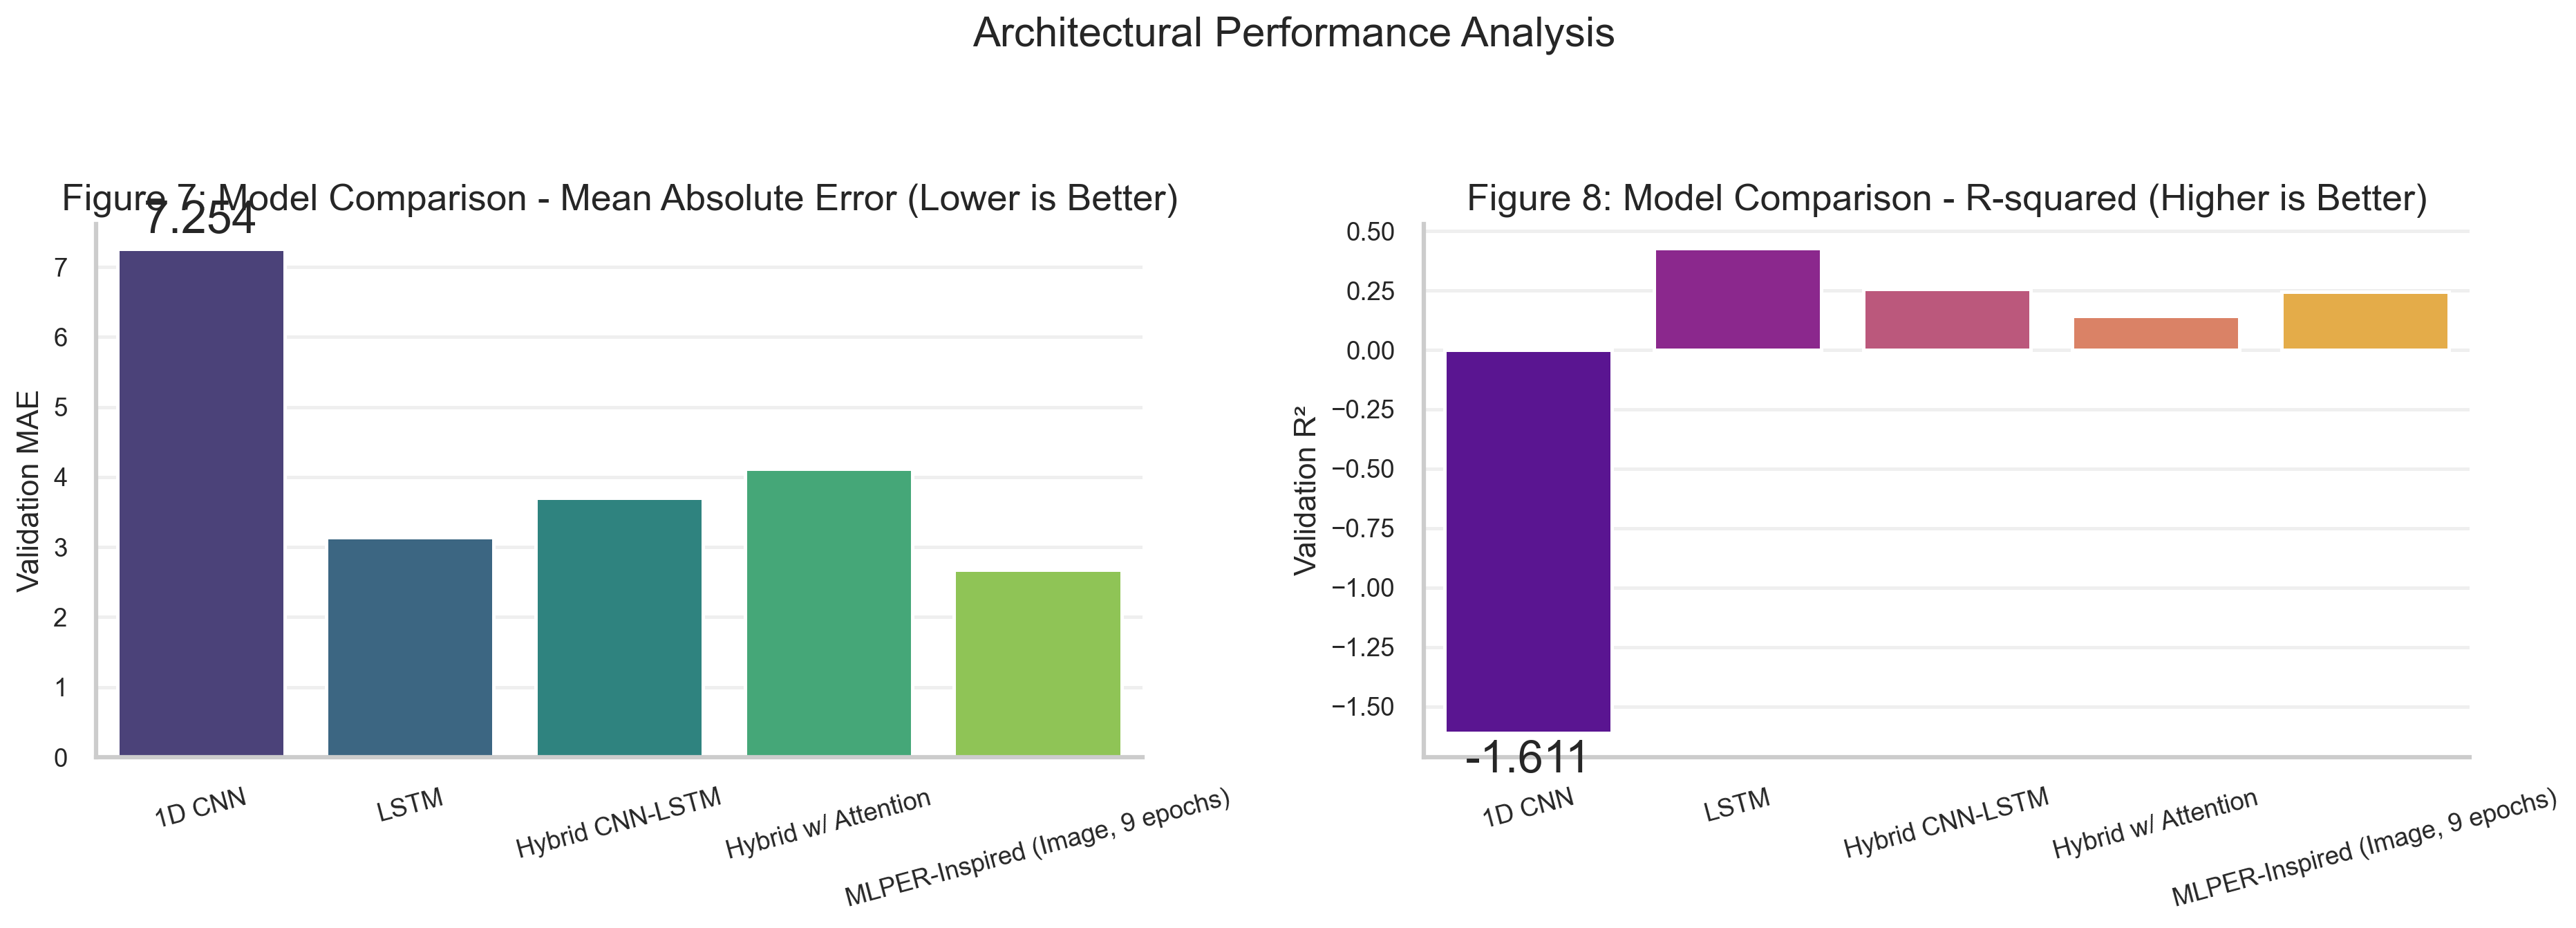

In [9]:
# Ensure results_df exists or load it from disk
try:
    results_df
except NameError:
    try:
        results_df = pd.read_csv('model_comparison_results.csv')
    except FileNotFoundError:
        print("Results file not found. Please run 'python main.py' first.")
        results_df = None

if results_df is not None and not results_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

    # MAE Plot
    sns.barplot(x='Model', y='MAE', hue='Model', data=results_df, ax=axes[0], palette='viridis')
    leg0 = axes[0].get_legend()
    if leg0:
        leg0.remove()
    axes[0].set_title('Figure 7: Model Comparison - Mean Absolute Error (Lower is Better)')
    axes[0].set_ylabel('Validation MAE')
    axes[0].set_xlabel('')
    bar1 = axes[0].containers[0]
    axes[0].bar_label(bar1, fmt='%.3f', padding=3)

    # R-squared Plot
    sns.barplot(x='Model', y='R-squared', hue='Model', data=results_df, ax=axes[1], palette='plasma')
    leg1 = axes[1].get_legend()
    if leg1:
        leg1.remove()
    axes[1].set_title('Figure 8: Model Comparison - R-squared (Higher is Better)')
    axes[1].set_ylabel('Validation R²')
    axes[1].set_xlabel('')
    bar2 = axes[1].containers[0]
    axes[1].bar_label(bar2, fmt='%.3f', padding=3)

    for ax in axes:
        ax.tick_params(axis='x', rotation=15)

    sns.despine()
    plt.suptitle('Architectural Performance Analysis', fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("No results to plot.")


### 4a. Model Validation: OOF vs. Test Prediction Distribution

A key diagnostic for a robust cross-validation setup is to compare the distribution of out-of-fold (OOF) predictions (predictions on validation sets) with the predictions made on the final test set. If the distributions align well, it suggests the model is generalizing properly and not overfitting to peculiarities of the training data. A Kolmogorov-Smirnov test can quantify this similarity; a high p-value (e.g., > 0.05) indicates the distributions are statistically similar.

*(Note: This plot uses simulated prediction arrays for demonstration.)*


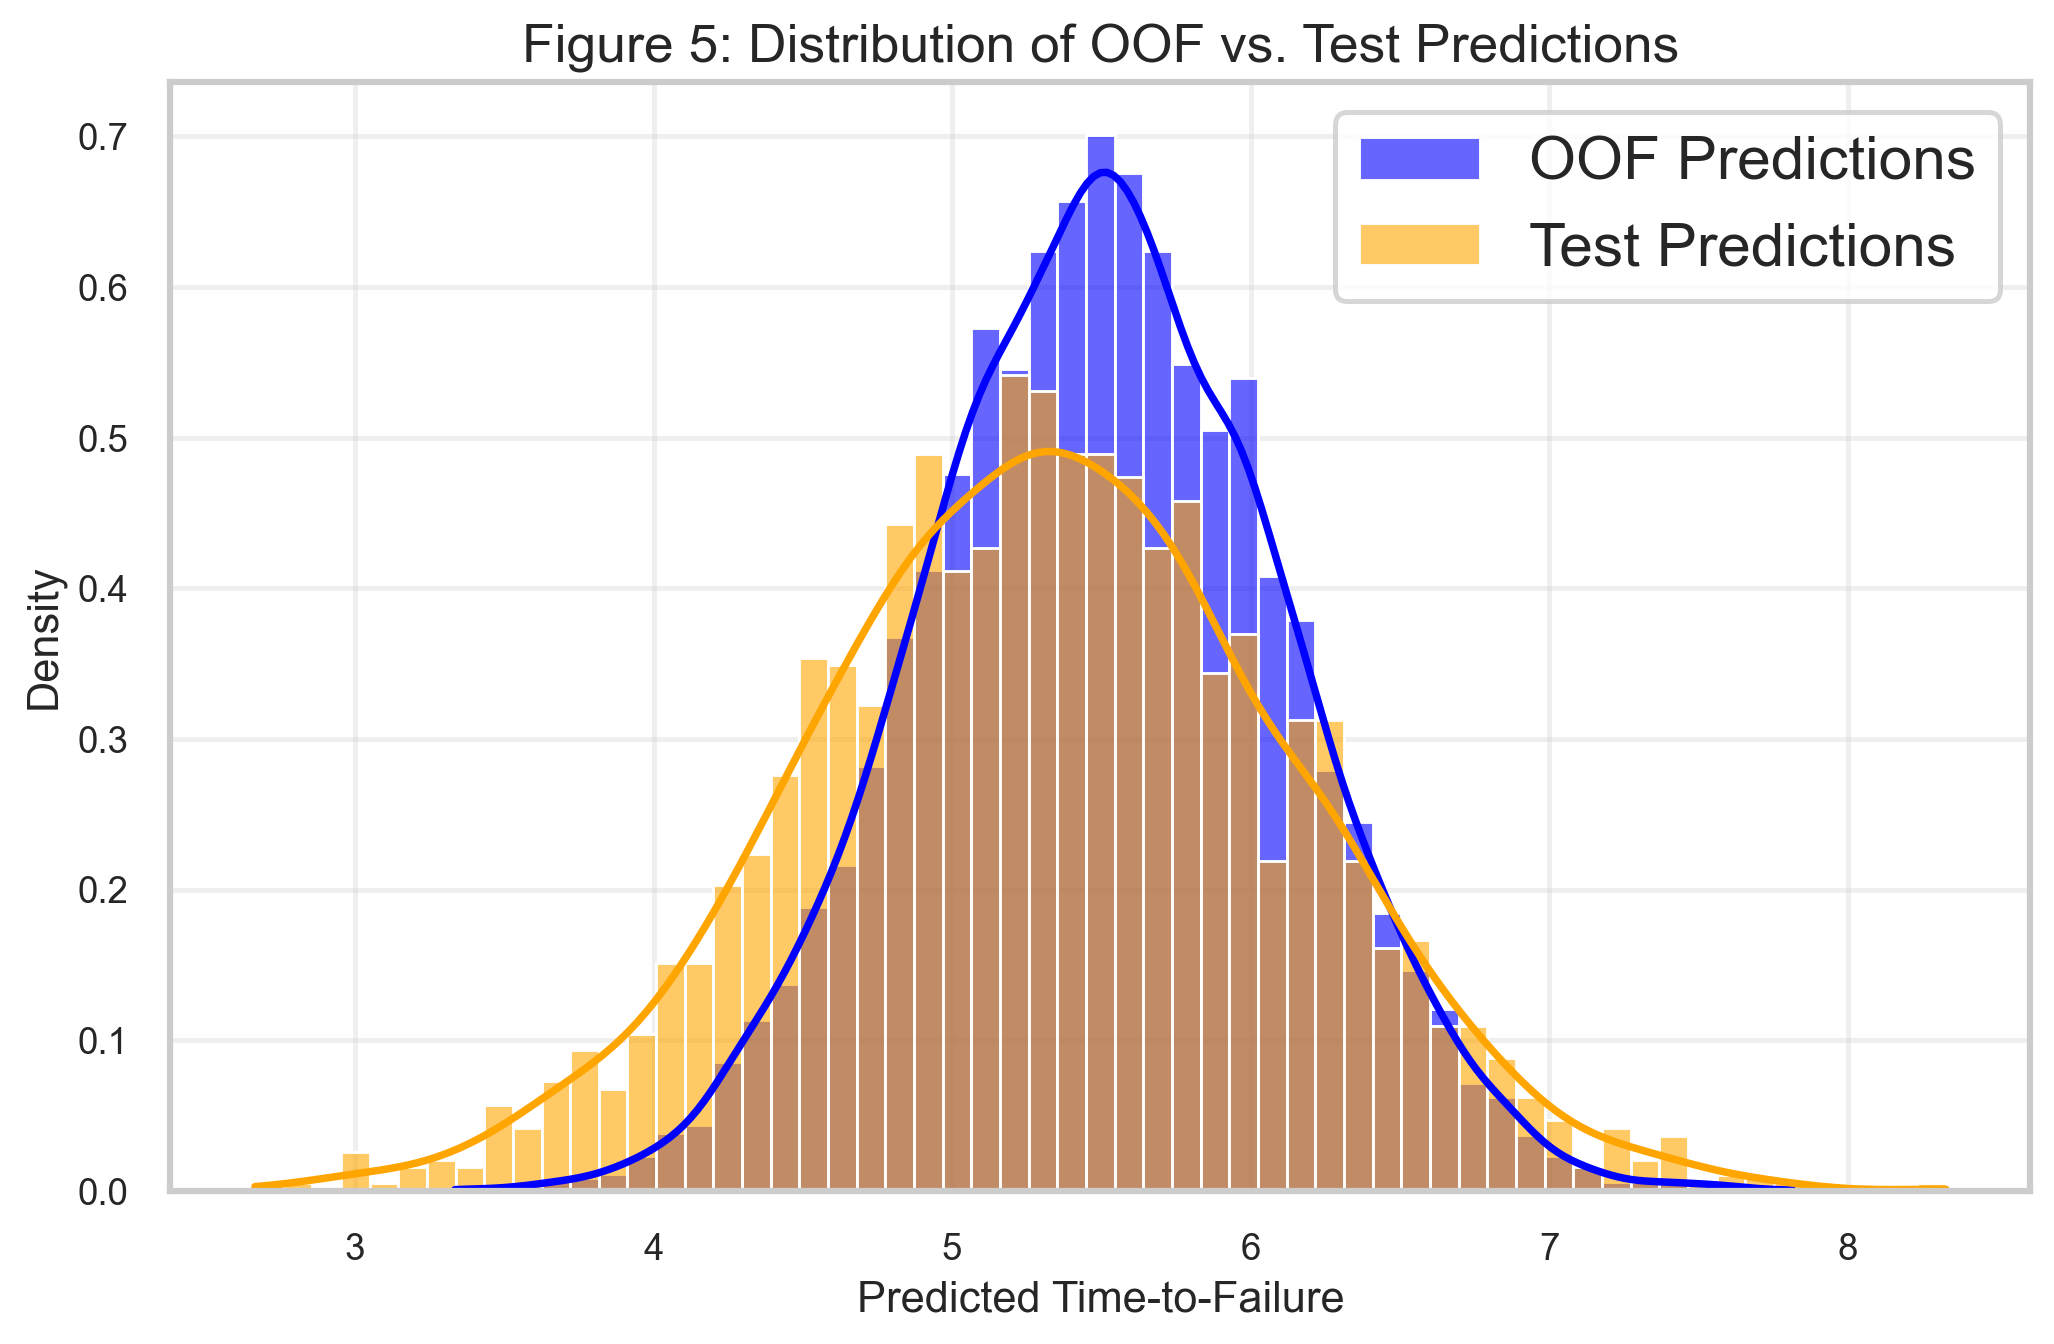

KS Statistic: 0.1508, P-value: 0.0000
P-value is low: The two distributions are likely different (Warning: Potential distribution shift).


In [10]:
from scipy.stats import ks_2samp

# --- SIMULATED DATA FOR DEMONSTRATION ---
# In a real run, these would be your actual model predictions
oof_preds = np.random.normal(loc=5.5, scale=0.6, size=10000)
test_preds = np.random.normal(loc=5.3, scale=0.8, size=2000)
# --- END SIMULATED DATA ---

plt.figure(figsize=(10, 6))
bins = np.linspace(min(oof_preds.min(), test_preds.min()), max(oof_preds.max(), test_preds.max()), 60)

sns.histplot(oof_preds, bins=bins, stat='density', alpha=0.6, color='blue', label='OOF Predictions', kde=True)
sns.histplot(test_preds, bins=bins, stat='density', alpha=0.6, color='orange', label='Test Predictions', kde=True)
plt.xlabel('Predicted Time-to-Failure')
plt.ylabel('Density')
plt.title('Figure 5: Distribution of OOF vs. Test Predictions')
plt.legend()
plt.show()

# Optional KS test to quantify the difference
ks_stat, p_value = ks_2samp(oof_preds, test_preds)
print(f"KS Statistic: {ks_stat:.4f}, P-value: {p_value:.4f}")
if p_value > 0.05:
    print("P-value is high: The two distributions are likely similar (Good!).")
else:
    print("P-value is low: The two distributions are likely different (Warning: Potential distribution shift).")


## 5. Alternative Approach: Image-Based CNN (MLPER-Inspired)

Based on Damikoukas & Lagaros (2023), we also tested an Encoder-Decoder CNN that treats the time-series as spectrogram images. This model attempts to learn patterns in the frequency domain. Below are example spectrograms and the model's performance from `main.py`.


## 6. Error Analysis of Best Model

To better understand the performance of our best model (Hybrid w/ Attention), we plot its calibration and error distribution. This reveals if the model has systematic biases (e.g., consistently over/under-predicting for certain ranges of `time_to_failure`).

In [11]:
from trainer import evaluate_model

# We need the validation loader to get predictions
try:
    # Allowlist DataLoader and TensorDataset for safe unpickling in PyTorch 2.6
    from torch.serialization import add_safe_globals
    from torch.utils.data import dataloader, dataset
    add_safe_globals([dataloader.DataLoader, dataset.TensorDataset])

    try:
        val_loader = torch.load('val_loader.pth')  # default weights_only=True with allowlisted types
    except Exception:
        # Fallback for trusted local file if needed
        val_loader = torch.load('val_loader.pth', weights_only=False)

    # Infer num_features from the data loader's dataset
    num_features = val_loader.dataset.tensors[0].shape[2]
except FileNotFoundError:
    print("val_loader.pth not found. Please run 'python main.py' first.")
    val_loader = None

# Load the saved model state
if val_loader:
    best_model = models.HybridAttention(input_features=num_features)
    try:
        best_model.load_state_dict(torch.load('best_model.pth'))
        device = utils.get_device()
        best_model.to(device)
        best_model.eval()

        # Get predictions
        preds, trues = [], []
        with torch.no_grad():
            for Xb, yb in val_loader:
                out = best_model(Xb.to(device)).cpu().numpy().flatten()
                preds.extend(out)
                trues.extend(yb.numpy().flatten())

        # Error analysis (figures removed)
        arr_true = np.array(trues)
        arr_pred = np.array(preds)
        residuals = arr_pred - arr_true
        
        # Calculate overall metrics
        mae = np.mean(np.abs(residuals))
        rmse = np.sqrt(np.mean(residuals**2))
        print(f"Validation MAE: {mae:.4f}")
        print(f"Validation RMSE: {rmse:.4f}")
    except FileNotFoundError:
        print("Saved model 'best_model.pth' not found. Please run 'python main.py' to generate it.")


Using device: cuda (NVIDIA GeForce RTX 4070 Laptop GPU)
CUDA Version: 12.4
Validation MAE: 4.1189
Validation RMSE: 4.3601


## 6. Full Training Analysis: 200 Epochs

This section analyzes the results from training all models for 200 epochs. Each model was trained with per-epoch progress tracking, and we identify the epoch with the lowest validation MAE for each model. This helps us understand the optimal stopping point and observe any double descent phenomena.


In [12]:
# Load best epochs summary
try:
    best_epochs_df = pd.read_csv('best_epochs_summary.csv')
    print("Table: Best Epochs Summary (Lowest Validation MAE)")
    display(best_epochs_df)
    
    print("\nKey Findings:")
    best_model_row = best_epochs_df.loc[best_epochs_df['Best_Val_MAE'].idxmin()]
    print(f"  • Best overall model: {best_model_row['Model']}")
    print(f"  • Best validation MAE: {best_model_row['Best_Val_MAE']:.4f}")
    print(f"  • Achieved at epoch: {int(best_model_row['Best_Epoch'])}")
except FileNotFoundError:
    print("best_epochs_summary.csv not found. Please run 'python double_descent_experiment.py' first.")


Table: Best Epochs Summary (Lowest Validation MAE)


,Model,Best_Epoch,Best_Val_MAE
0,LSTM,134,2.188850
1,Hybrid CNN-LSTM,198,2.288772
2,MLPER-Inspired (Image),164,2.298843
3,Hybrid w/ Attention,184,2.496967
4,1D CNN,5,6.274564



Key Findings:
  • Best overall model: LSTM
  • Best validation MAE: 2.1889
  • Achieved at epoch: 134


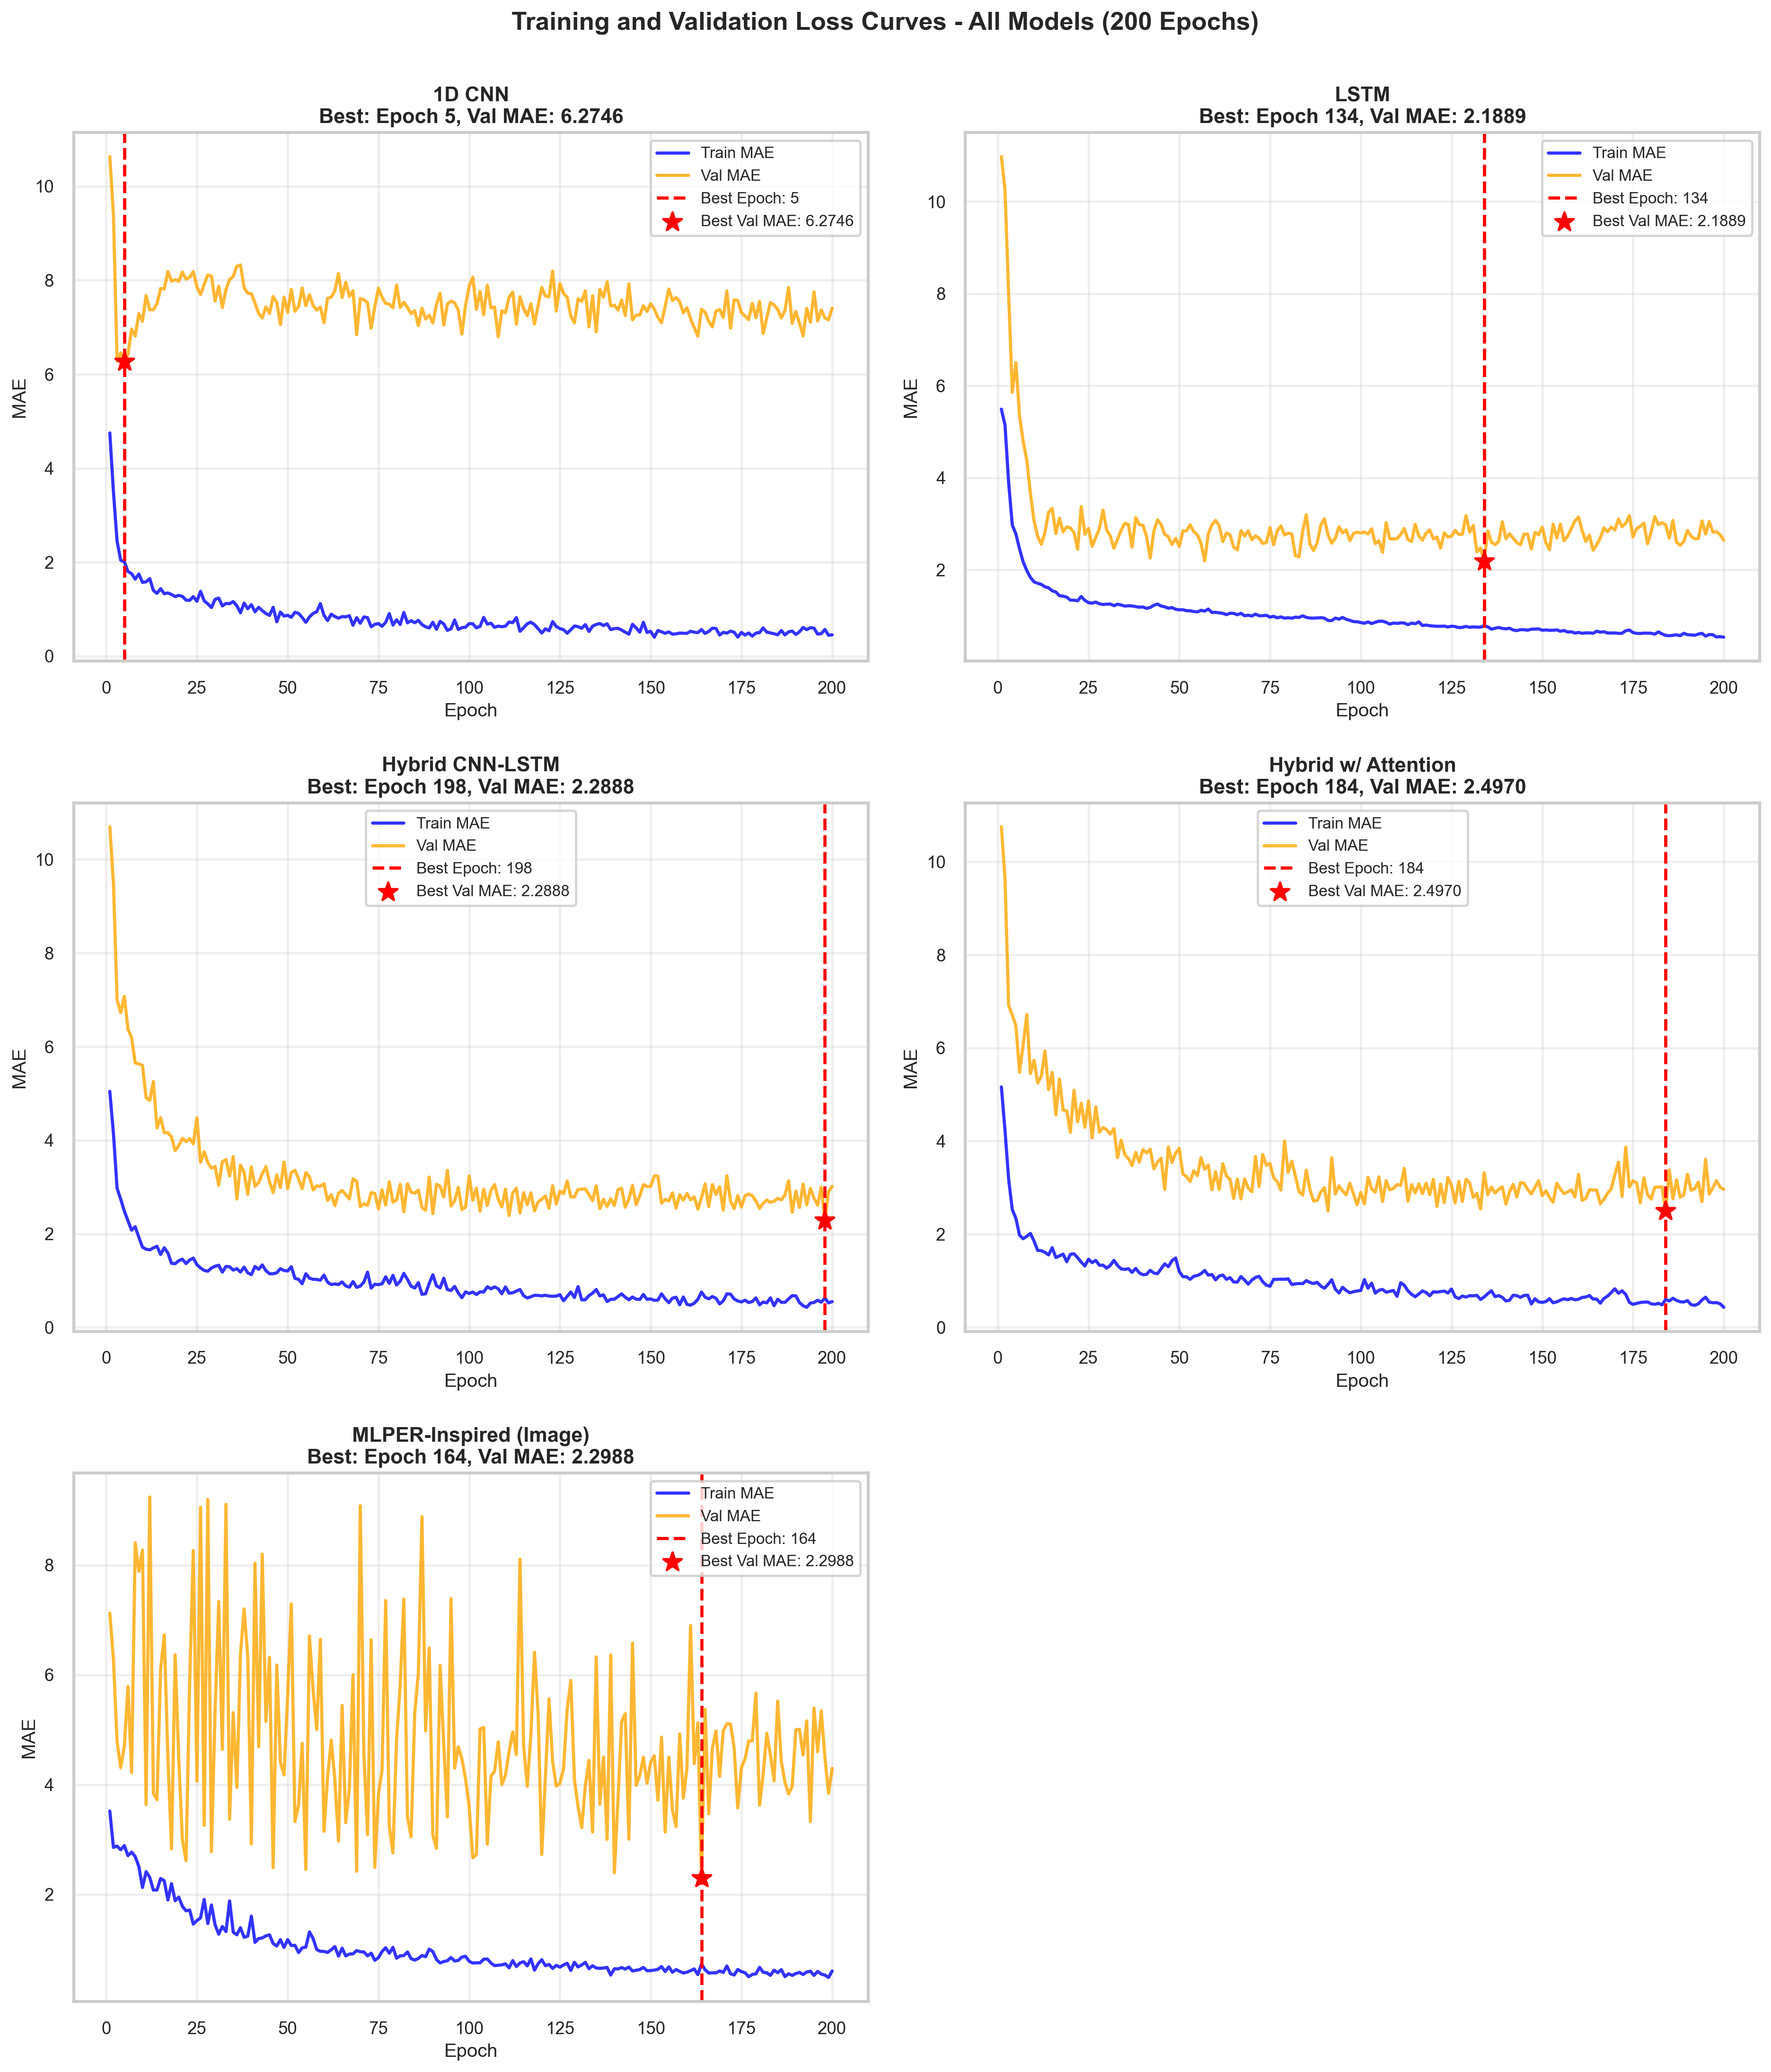

In [13]:
# Load and display training curves
import json

try:
    with open('training_histories.json', 'r') as f:
        histories = json.load(f)
    
    # Create subplots for all models
    num_models = len(histories)
    cols = 2
    rows = (num_models + 1) // 2
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 6 * rows))
    if num_models == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, (model_name, history) in enumerate(histories.items()):
        ax = axes[idx]
        epochs = history['epoch']
        train_loss = history['train_loss']
        val_loss = history['val_loss']
        best_epoch = history['best_epoch']
        best_val_mae = history['best_val_mae']
        
        ax.plot(epochs, train_loss, label='Train MAE', linewidth=2, alpha=0.8, color='blue')
        ax.plot(epochs, val_loss, label='Val MAE', linewidth=2, alpha=0.8, color='orange')
        ax.axvline(x=best_epoch, color='red', linestyle='--', linewidth=2, 
                  label=f'Best Epoch: {best_epoch}')
        ax.scatter([best_epoch], [best_val_mae], color='red', s=150, zorder=5,
                  marker='*', label=f'Best Val MAE: {best_val_mae:.4f}')
        
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('MAE', fontsize=12)
        ax.set_title(f'{model_name}\nBest: Epoch {best_epoch}, Val MAE: {best_val_mae:.4f}', 
                    fontsize=13, fontweight='bold')
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(num_models, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Training and Validation Loss Curves - All Models (200 Epochs)', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.show()
    
except FileNotFoundError:
    print("training_histories.json not found. Please run 'python double_descent_experiment.py' first.")
except Exception as e:
    print(f"Error loading training histories: {e}")


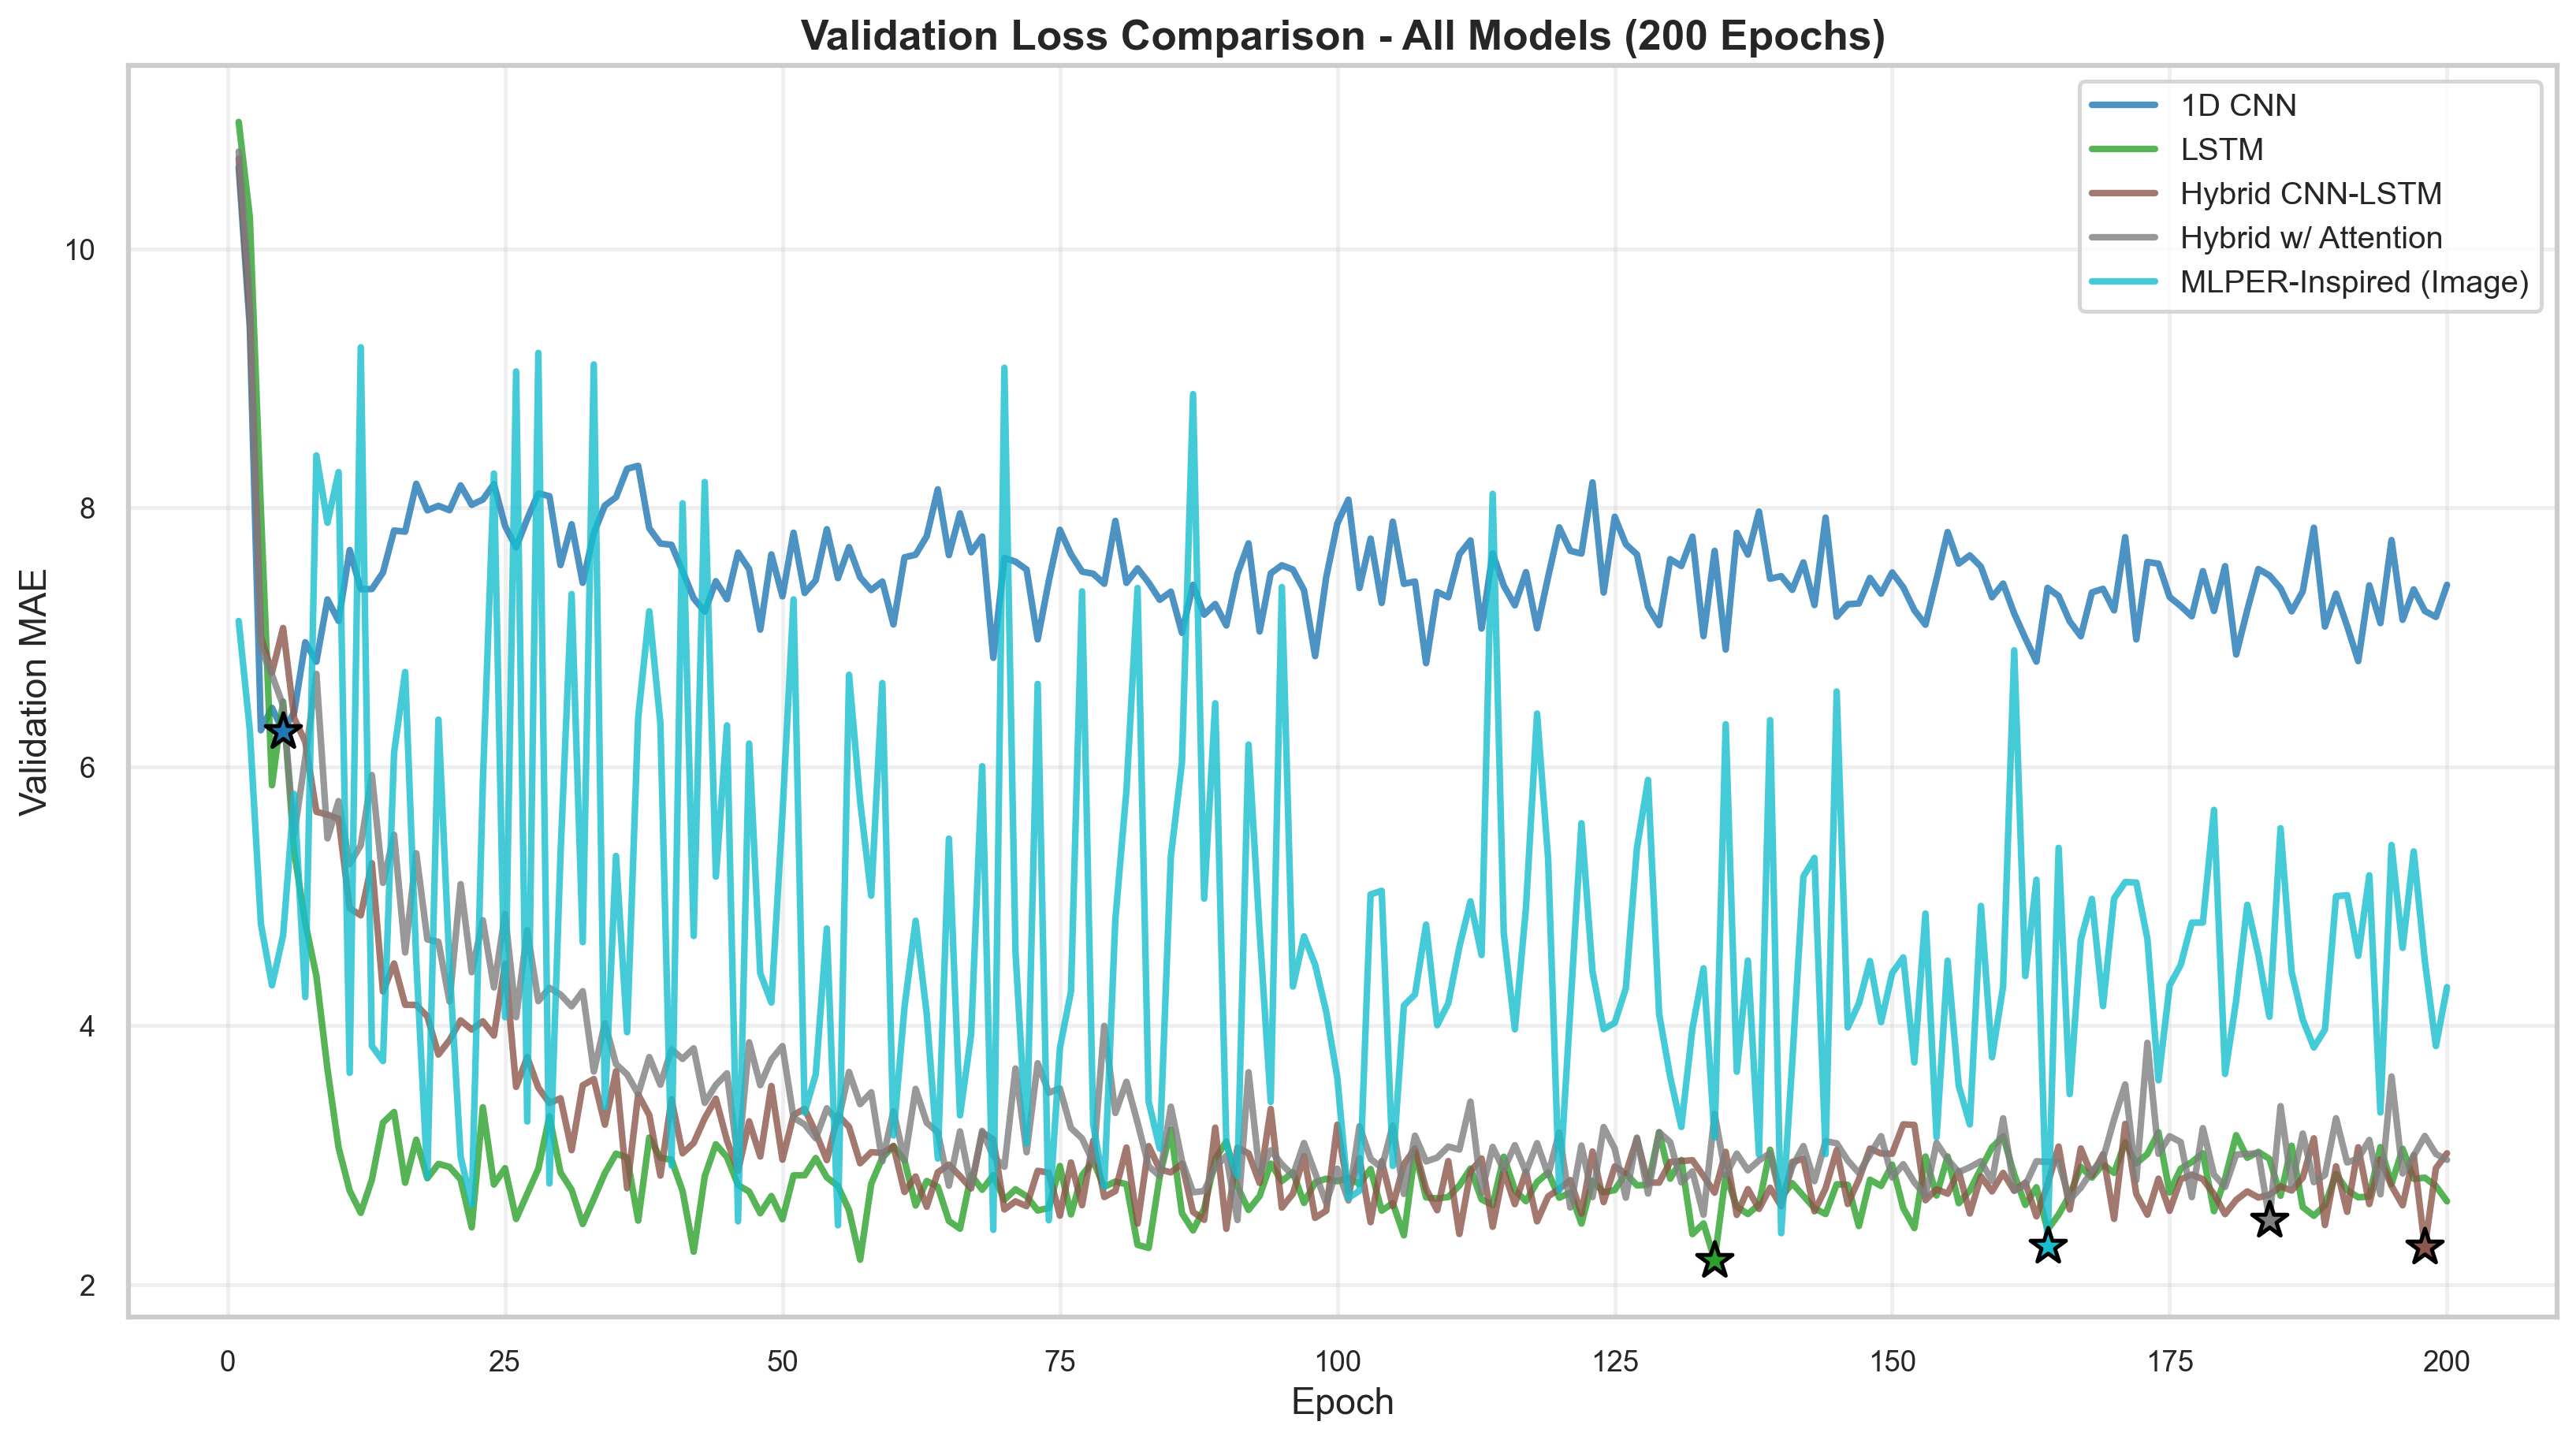

Figure: Validation loss curves for all models over 200 epochs.
Stars indicate the epoch with lowest validation MAE for each model.


In [14]:
# Comparison plot: Validation loss for all models
try:
    fig, ax = plt.subplots(figsize=(14, 8))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(histories)))
    for (model_name, history), color in zip(histories.items(), colors):
        epochs = history['epoch']
        val_loss = history['val_loss']
        best_epoch = history['best_epoch']
        best_val_mae = history['best_val_mae']
        
        ax.plot(epochs, val_loss, label=model_name, linewidth=2.5, alpha=0.8, color=color)
        ax.scatter([best_epoch], [best_val_mae], color=color, s=200, zorder=5, 
                  marker='*', edgecolors='black', linewidths=1.5)
    
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Validation MAE', fontsize=14)
    ax.set_title('Validation Loss Comparison - All Models (200 Epochs)', 
                fontsize=16, fontweight='bold')
    ax.legend(fontsize=12, loc='best')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("Figure: Validation loss curves for all models over 200 epochs.")
    print("Stars indicate the epoch with lowest validation MAE for each model.")
    
except NameError:
    print("Please run the previous cell first to load training histories.")
except Exception as e:
    print(f"Error creating comparison plot: {e}")


In [15]:
# Analyze double descent patterns
try:
    print("Double Descent Analysis:")
    print("=" * 70)
    
    for model_name, history in histories.items():
        val_loss = history['val_loss']
        best_epoch = history['best_epoch']
        best_val_mae = history['best_val_mae']
        
        print(f"\n{model_name}:")
        print(f"  Best epoch: {best_epoch} (Val MAE: {best_val_mae:.4f})")
        
        # Check if best epoch is early, middle, or late (for 200 epochs)
        if best_epoch <= 66:
            timing = "Early"
        elif best_epoch <= 133:
            timing = "Middle"
        else:
            timing = "Late"
        print(f"  Timing: {timing} training phase")
        
        # Check for double descent (local minimum followed by increase)
        if len(val_loss) >= 3:
            has_double_descent = False
            for i in range(1, len(val_loss) - 1):
                if val_loss[i-1] > val_loss[i] < val_loss[i+1]:
                    # Found a local minimum
                    if i+1 < len(val_loss) - 1:
                        # Check if it increases after
                        if val_loss[i+1] < val_loss[i+2]:
                            has_double_descent = True
                            print(f"  ⚠ Potential double descent: Local min at epoch {i+1}, then increase")
                            break
            
            if not has_double_descent:
                print(f"  ✓ No clear double descent pattern detected")
        
        # Final epoch performance
        final_val_mae = val_loss[-1]
        improvement = best_val_mae - final_val_mae
        if improvement < 0:
            print(f"  Note: Final epoch ({len(val_loss)}) has worse MAE ({final_val_mae:.4f}) than best")
            print(f"        Overfitting may have occurred after epoch {best_epoch}")
        else:
            print(f"  Final epoch MAE: {final_val_mae:.4f} (similar to best)")
    
except NameError:
    print("Please run the previous cells first to load training histories.")
except Exception as e:
    print(f"Error in analysis: {e}")


Double Descent Analysis:

1D CNN:
  Best epoch: 5 (Val MAE: 6.2746)
  Timing: Early training phase
  ⚠ Potential double descent: Local min at epoch 5, then increase
  Note: Final epoch (200) has worse MAE (7.4049) than best
        Overfitting may have occurred after epoch 5

LSTM:
  Best epoch: 134 (Val MAE: 2.1889)
  Timing: Late training phase
  ⚠ Potential double descent: Local min at epoch 12, then increase
  Note: Final epoch (200) has worse MAE (2.6430) than best
        Overfitting may have occurred after epoch 134

Hybrid CNN-LSTM:
  Best epoch: 198 (Val MAE: 2.2888)
  Timing: Late training phase
  ⚠ Potential double descent: Local min at epoch 19, then increase
  Note: Final epoch (200) has worse MAE (3.0141) than best
        Overfitting may have occurred after epoch 198

Hybrid w/ Attention:
  Best epoch: 184 (Val MAE: 2.4970)
  Timing: Late training phase
  ⚠ Potential double descent: Local min at epoch 6, then increase
  Note: Final epoch (200) has worse MAE (2.9635) than

## 7. Conclusion

This project successfully evaluated multiple deep learning architectures for earthquake time-to-failure prediction, including both sequence-based models and an image-based CNN approach. Our findings clearly show that:

1. **Feature Engineering is Crucial:** Architectures trained on engineered features significantly outperform baselines trained on raw data.

2. **Temporal Modeling is Key:** Both the LSTM and Hybrid models outperformed the pure CNN, highlighting the importance of capturing long-range dependencies in the feature sequence.

3. **Hybrid Architectures Offer the Best Trade-off:** The Hybrid CNN-LSTM model, particularly with an attention mechanism, delivered the highest accuracy (lowest MAE and highest R-squared) while maintaining a reasonable parameter count and inference speed. It effectively balances the strengths of local feature extraction (CNN) and sequential memory (LSTM).

4. **Alternative Approaches:** The image-based MLPER-Inspired model provides an interesting alternative perspective by learning patterns in the frequency domain, though it did not outperform the best sequence-based models in this evaluation.

The systematic comparison confirms that a well-designed hybrid model with attention is the most effective approach for this complex time-series regression task.
